# Project 2: Potential Flow

#### Author: Jack Comey

##### Student ID: 915323775
##### Due Date: 11:59 PM Monday 02 NOV 2020

###### Code Imports and Basic Function Definition:

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 29 09:57:10 2020

@author: jack

EAE 127 Project 2

Stream sources and sink superposition project
"""

# Imports 

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("classic")

In [2]:
def NACAThicknessEquation(N, A, CA, num_points, *, use_other_x_points=0):
    """
    Generates a non-dimensionalized NACA airfoil given NACA numbers.

    Parameters
    ----------
    N : Ratio of max camber to chord length
    A : Location of max camber
    CA : Thickness ratio 
    num_points : Number of points for airfoil


    Returns
    -------
    x_non_dim_full : List of non-dimenionalized points from 0 to 1 to 0
    z : Airfoil non-dimensionalized z poisition from xc = 0 to 1 to 0
    zcc : Chord line

    """
    p = 0.1 * A
    m = 0.01 * N
    t = 0.01 * CA
    if use_other_x_points is not 0:
        x_non_dim = use_other_x_points
    else:
        x_non_dim = np.linspace(0, 1, num_points)
    
    ztc = x_non_dim*0
    
    # Find thickness relative to camber
    ztc += 0.2969 * (x_non_dim**0.5)
    ztc -= 0.1260 * (x_non_dim**1)
    ztc -= 0.3516 * (x_non_dim**2)
    ztc += 0.2843 * (x_non_dim**3)
    ztc -= 0.1015 * (x_non_dim**4)
    
    ztc *= t/0.2
    
    
    # Find camber line
    zcc = 0*x_non_dim
    try:
        for i in zip(*np.where(x_non_dim <= p)):
            zcc[i] = 2*p*x_non_dim[i]
            zcc[i] -= x_non_dim[i]**2
            zcc[i] *= m * p**-2
    
        for i in zip(*np.where(x_non_dim > p)):
            zcc[i] = 1 - 2*p
            zcc[i] += 2*p*x_non_dim[i]
            zcc[i] -= x_non_dim[i]**2
            zcc[i] *= m * (1-p)**-2

    except:
        zcc = 0*x_non_dim


    # Sum the two
    zup = zcc + ztc
    zdown = zcc - ztc
    
    x_non_dim = np.concatenate((x_non_dim, np.flip(x_non_dim)))
    z = np.concatenate((zup, np.flip(zdown)))
    return x_non_dim, z


def plothusly(ax, x, y, *, xtitle='', ytitle='',
              datalabel='', title='', linestyle='-',
              marker=''):
    """
    A little function to make graphing less of a pain.
    Creates a plot with titles and axis labels.
    Adds a new line to a blank figure and labels it.

    Parameters
    ----------
    ax : The graph object
    x : X axis data
    y : Y axis data
    xtitle : Optional x axis data title. The default is ''.
    ytitle : Optional y axis data title. The default is ''.
    datalabel : Optional label for data. The default is ''.
    title : Graph Title. The default is ''.

    Returns
    -------
    out : Resultant graph.

    """

    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.set_title(title)
    out = ax.plot(x, y, zorder=1, label=datalabel, linestyle = linestyle,
                  marker = marker)
    plt.grid()
    plt.legend(loc='best')
    return out


def plothus(ax, x, y, *, datalabel='', linestyle = '-',
            marker = ''):
    """
    A little function to make graphing less of a pain

    Adds a new line to a blank figure and labels it
    """
    out = ax.plot(x, y, zorder=1, label=datalabel, linestyle = linestyle,
                  marker = marker)
    plt.legend(loc='best')

    return out

## 1 | Freestream/Source Superposition

The goal for **Problem 1** is as follows: 

* Derive the equations for the stagnation point and the dividing streamline, beginning with with Equation 3.75 from the Anderson book.
* Create code to simulate the superposition of uniform and source flow. In a _single_ figure, for source strength $\Lambda = 2.1$, plot and label:
    * **Streamlines**
    * **Velocity Potential Contours**
    * **Dividing Streamline**
    * **Dividing Streamline Diameter**
    * **Source Location**
    * **Stagnation point location**

### 1.1 | Approach

Given that a significant portion of this project relies on superposition of uniform, source, and sink flows, it is a good idea to generalize the entire process into a single function as to save time in the future. The overall process for this would be:

* Create a model for a general source/sink
* Create a function which accepts a list of source strengths, and locations, and then creates each source using their respective properties
* Determine velocity field, potential, and streamlines using the superposition of the uniform and source flows
* Determine the dividing streamline and stagnation points from $\psi$
* Plot on a single plot

The first step is to model a source or sink. While the tutorial provided in the problem statement provides a good way to generalize a single source/sink, it will be cumbersome to do so for a large number of source/sink singularities (such as in **Problem 3**). Instead, a generalized source _object_ can be created, and given properties of position ($x$, $y$), and strength $\Lambda$. These objects can then be stored in a list, and the list can then be iterated over to get $u$, $v$, $\psi$, and $\phi$ for each.

Now that the fluid singularity has been generalized to an object, a function can be made which accepts a list of singularity properties in order to create the superimposed flow, in addition to $u_\infty$, $v_\infty$, and X and Y meshgrids.

Meshgrids for $u$, $v$, $\psi$, and $\phi$ totals were created so as to hold the sums of the superimposed flow. The freestream properties are created and added first. The list of sources is iterated over, and the $u$, $v$, $\psi$, and $\phi$ values for each source are added to the total meshgrid, as allowed by the principle of superposition.

The list of sources and sinks is then made by creating an appropriately sized array, corresponding to the respective number of sources and sinks (identified by positive or negative strength values). Each source/sink is then indexed, and the $x$-$y$ coordinates of the singularity are then put into a list. These points can then be added to the plot using the ```plt.scatter()``` function, distinguished from each other by color, and then identified in the legend.

The streamlines can be plotted using pyplot's ```plt.streamplot()``` function, and the dividing streamline can be shown using pyplot's ```plt.contour()``` function, using $\pm\frac{\Lambda}{2}$ as the dividing level for the function. As this code is to be reused, an ```if``` statement is used to show only the dividing streamline at a level of ```levels=[0.]``` if multiple sources are used (following the example).

### 1.2 | Equations

For the derivation, Eq 3.75 (Anderson) is given as:

$$\begin{equation}
    \psi = V_\infty r sin(\theta) + \frac{\Lambda}{2\pi} \theta = const.
\end{equation}$$

where the first term is the uniform flow, and the second is the flow created by a source of strength $\Lambda$.



Radial value $r$ can be expressed in terms of $x$-$y$ coordinates as:

$$\begin{equation}
    r = \sqrt{x^2 + y^2}
\end{equation}$$

Angle value $\theta$ can be expressed in terms of $x$-$y$ coordinates as:

$$\begin{equation}
    \theta = tan^{-1}(\frac{y}{x})
\end{equation}$$

The equation for $\phi$ for freestream flow is given as (from Anderson):

$$\begin{equation}
    \phi = V_\infty x
\end{equation}$$

The equation for $\psi$ for freestream flow is given as (from Anderson):

$$\begin{equation}
    \psi = V_\infty y
\end{equation}$$

The equation for $\phi$ for source flow is given as (from Anderson):

$$\begin{equation}
    \phi = \frac{\Lambda}{2\pi} \ln{r} = \frac{\Lambda}{2\pi} \ln{\sqrt{(x - x_s)^2 + (y-y_s)^2}}
\end{equation}$$

The equation for $\psi$ for source flow is given as (from Anderson):

$$\begin{equation}
    \psi = \frac{\Lambda}{2\pi} \theta = \frac{\Lambda}{2\pi} tan^{-1}(\frac{y-y_s}{x-x_s})
\end{equation}$$


### 1.3 | Code and Results


##### Derivation
Beginning with Equation 3.75, expressed as:

$$\begin{equation}
    \psi = V_\infty r sin(\theta) + \frac{\Lambda}{2\pi} \theta = const.
\end{equation}$$

The radial velocity can be determined from the stream function by taking the partial derivative with respect to $\theta$:

$$\begin{equation}
    V_r = \frac{1}{r} \frac{\partial}{\partial \theta} \psi =  \frac{\partial}{\partial \theta} (V_\infty r sin(\theta) + \frac{\Lambda}{2\pi} \theta)
\end{equation}$$

$$\begin{equation}
    V_r = V_\infty cos \theta + \frac{\Lambda}{2\pi r}
\end{equation}$$

Likewise, the rotational velocity can be determined by taking the partial derivative with respect to $r$:

$$\begin{equation}
    V_\theta = -\frac{\partial}{\partial r} \psi =  -\frac{\partial}{\partial r} (V_\infty r sin(\theta) + \frac{\Lambda}{2\pi} \theta)
\end{equation}$$

$$\begin{equation}
    V_\theta = -V_\infty sin \theta
\end{equation}$$

The stagation point is defined as the point at which fluid velocity is zero, and can be found by setting the value of the derived equations to zero ($V_r = 0$, $V_\theta = 0$). Beginning with $V_r$:

$$\begin{equation}
    V_r = V_\infty cos \theta + \frac{\Lambda}{2\pi r} = 0
\end{equation}$$

Substituting $\theta$ for cartesian coordinates:

$$\begin{equation}
    0 = V_\infty \frac{x - x_{source}}{r} + \frac{\Lambda}{2\pi r}
\end{equation}$$

Multiplying both terms by $r$:

$$\begin{equation}
    0 = V_\infty (x - x_{source}) + \frac{\Lambda}{2\pi}
\end{equation}$$

Solving for $x$:

$$\begin{equation}
    V_\infty x = - (-x_{source} V_\infty +  \frac{\Lambda}{2\pi})
\end{equation}$$

Resulting in:

$$\begin{equation}
    x = x_{source} - \frac{\Lambda}{2\pi V_\infty }
\end{equation}$$


The same can be done for $V_\theta$:

$$\begin{equation}
    V_\theta = -V_\infty sin \theta = 0
\end{equation}$$

$$\begin{equation}
    0 = -V_\infty \frac{y - y_{source}}{r}
\end{equation}$$

$$\begin{equation}
    0 = V_\infty (y - y_{source})
\end{equation}$$

$$\begin{equation}
    y = y_{source}
\end{equation}$$


The diameter of the dividing streamline can be found by solving the streamline equation:

$$\begin{equation}
    \psi = V_\infty r sin(\theta) + \frac{\Lambda}{2\pi} \theta = 0
\end{equation}$$

for $r$ evaluated at $\theta = \frac{\pi}{2}$. Solving for $r$:

$$\begin{equation}
    \psi = V_\infty r sin(\frac{\pi}{2}) + \frac{\Lambda}{2\pi} \frac{\pi}{2} = 0
\end{equation}$$

$$\begin{equation}
    \psi = V_\infty r + \frac{\Lambda}{4} = 0
\end{equation}$$

$$\begin{equation}
    r = - \frac{\Lambda}{4 V_\infty}
\end{equation}$$

$$\begin{equation}
    |D| = |2r| = \frac{\Lambda}{2 V_\infty}
\end{equation}$$

##### Code and Results

In order to create the stream plot, the source object is first created:

In [3]:
class Source():
    
    def __init__(self, x, y, strength):
        """
        Generates a source/sink at given coordinates, with a given strength.
        Positive strength indiates source, negative strenght indicates sink.

        Parameters
        ----------
        x : X coordinate of source
        y : Y coordinate of source
        strength : Capital lambda, source strength

        Returns
        -------
        None.

        """
        
        self.pos = np.array([[x],
                             [y]])
        self.strength = strength
        
    
    def GetStreamFunction(self, Xmesh, Ymesh):
        """
        Finds meshgrid for streamfuntion psi

        Parameters
        ----------
        Xmesh : Control X meshgrid
        Ymesh : Control Y meshgrid

        Returns
        -------
        psi_mesh : Stream function meshgrid

        """
        psi_mesh = self.strength / (2*np.pi) * np.arctan2((Ymesh - self.pos[1]),
                                                         (Xmesh - self.pos[0]))
        return psi_mesh
    
    def GetStreamPotential(self, Xmesh, Ymesh):
        
        phi_mesh = self.strength / (2*np.pi) * np.log(((Xmesh - self.pos[0])**2 
                                                       + (Ymesh - self.pos[1])**2)**0.5)

        return phi_mesh

    def GetVelocity(self, Xmesh, Ymesh):
        """
        Returns stream velocity mesh grids for the source.

        Parameters
        ----------
        Xmesh : Control X meshgrid
        Ymesh : Control Y meshgrid

        Returns
        -------
        umesh : u component meshgrid
        vmesh : v component meshgrid

        """
        umesh = self.strength / (2*np.pi)
        umesh *= (Xmesh - self.pos[0])
        umesh /= ((Xmesh - self.pos[0])**2 + (Ymesh - self.pos[1])**2)
        
        vmesh = self.strength / (2*np.pi)
        vmesh *= (Ymesh - self.pos[1])
        vmesh /= ((Xmesh - self.pos[0])**2 + (Ymesh - self.pos[1])**2)
        
        return umesh, vmesh

        

The general superposition function is then created:

In [4]:
def CreateStreamPlot(source_x_list, source_y_list, source_l_list, u_inf, v_inf, X, Y, N):
    """
    

    Parameters
    ----------
    source_x_list : List of source x-coords
    source_y_list : List of source y-coords
    source_l_list : List of source strengths
    u_inf : Freestream U
    v_inf : Freestream V
    X : X Meshgrid
    Y : Y Meshgrid

    Returns
    -------
    streamplot : Plot of superimposed fluid flow

    """
    # Creates empty list to store source objects
    n = len(source_x_list)
    source_sink_objs = np.empty((n, 1), dtype=object)
    
    
    # Creates the source objects given input properties and stores
    # them in the list
    i = 0
    for x, y, l in zip(source_x_list, source_y_list, source_l_list):
        source_sink_objs[i] = Source(x, y, l)
        i += 1
    
    # Creates freestream velocity field
    u_freestream = u_inf * np.ones((N, N))
    v_freestream = v_inf * np.ones((N, N))
    psi_freestream = u_inf * Y
    phi_freestream = u_inf * X

    # Creates Total sum field
    u_total = np.zeros((N, N))
    v_total = np.zeros((N, N))
    psi_total = np.zeros((N, N))
    phi_total = np.zeros((N, N))
    
    # Adds freestream to total
    u_total += u_freestream
    v_total += v_freestream
    psi_total += psi_freestream
    phi_total += phi_freestream


    # Adds sources and sinks to total field
    for i in range(len(source_sink_objs)):
        u_source , v_source = source_sink_objs[i].item().GetVelocity(X, Y)
        psi_source = source_sink_objs[i].item().GetStreamFunction(X, Y)
        phi_source = source_sink_objs[i].item().GetStreamPotential(X, Y)
        u_total += u_source
        v_total += v_source
        psi_total += psi_source
        phi_total += phi_source


    # Creates a list of sources and a list of sinks from inputs
    # This works, don't touch it
    x_source = np.zeros((len(np.where(source_l_list > 0)[0]), 1))
    y_source= np.zeros((len(np.where(source_l_list > 0)[0]), 1))
    x_sink = np.zeros((len(np.where(source_l_list < 0)[0]), 1))
    y_sink = np.zeros((len(np.where(source_l_list < 0)[0]), 1))

    # Creates list of source coordinates
    k = 0
    for i in zip(*np.where(source_l_list > 0)):
        x_source[k], y_source[k] = source_x_list[i], source_y_list[i]
        k += 1
    
    # Creates list of sink coordinates
    k = 0
    for i in zip(*np.where(source_l_list < 0)):
        x_sink[k], y_sink[k] = source_x_list[i], source_y_list[i]
        k += 1
    

    # Creates streamline plot
    fig, streamplot = plt.subplots()
    plt.grid(True)
    plt.xlabel("X Direction")
    plt.ylabel("Y Direction")
    plt.streamplot(X, Y, u_total, v_total, 
                    density = 2.5, linewidth = 0.4, arrowsize=0.8,
                    )
    plt.title("Stream Plot")
    plt.scatter(x_source, y_source, s=40, marker='o', color='red',label='Sources')
    plt.scatter(x_sink, y_sink, s=40, marker='o', color='black', label="Sinks")
    
    # For 1 source
    if len(source_l_list) < 2:
        
        # Contour
        plt.contour(X, Y, psi_total, levels=[-source_l_list[0]/2, source_l_list[0]/2], colors='red', linestyles='solid', alpha = 1)
        
        # Stagnation Point
        xstag = source_sink_objs[0].item().pos[0] - source_sink_objs[0].item().strength/(2*np.pi*u_inf)
        ystag = source_sink_objs[0].item().pos[1]
        plt.scatter(xstag, ystag, s=60, color='green', label='Stagnation Point')
        
        # Dividing SL diameter
        source_diameter_function = lambda Vinf, Lambda: (Lambda/(2*Vinf))
        divSL = source_diameter_function(u_inf, source_l_list[0])
        divSLdat = np.linspace(-divSL/2, divSL/2, 10)
        divSLxdat = divSLdat * 0
        plt.plot(divSLxdat, divSLdat, linewidth = 2, label=f"Dividing SL Diameter = {divSL:.2f} ft")
        
    # All other cases
    else:
        plt.contour(X, Y, psi_total, levels=[0.], linewidths=2, colors='red', linestyles='dashdot', alpha=1)
        
    # Potential
    plt.contour(X, Y, phi_total, colors='black', linestyles='--')
    plt.legend(loc='upper left')
    # plt.axis('equal')
    
    return streamplot

The necessary inputs are created, and the function is called:

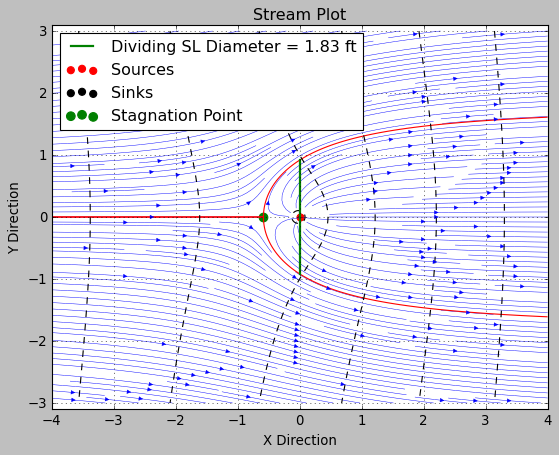

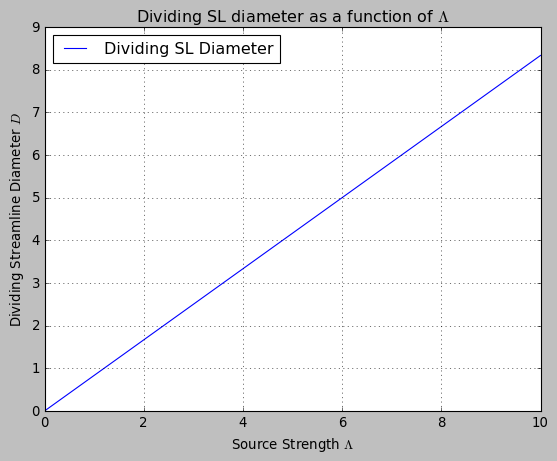

In [5]:
source_x_list = np.array([0])
source_y_list = np.array([0])
source_l_list = np.array([2.2])

u_inf = 0.6
v_inf = 0

N = 1000

x_bounds = np.linspace(-4, 4, N)
y_bounds = np.linspace(-3, 3, N)

X, Y = np.meshgrid(x_bounds, y_bounds)


CreateStreamPlot(source_x_list, source_y_list, source_l_list, u_inf, v_inf, X, Y, N)
plt.axis('equal')

source_diameter_function = lambda Vinf, Lambda: (Lambda/(2*Vinf))

source_list = np.linspace(0, 10, 100)
dia_list = source_diameter_function(u_inf, source_list)

fig, diaplot = plt.subplots()
plothusly(diaplot, source_list, dia_list,
          xtitle=r"Source Strength $\Lambda$",
          ytitle=r"Dividing Streamline Diameter $D$",
          title=r"Dividing SL diameter as a function of $\Lambda$",
          datalabel="Dividing SL Diameter")

Note that the velocity potential (black dashed lines) intersect perpendicularly with the streamlines, as expected. Also note that the diameter of the dividing streamline has a linear relationship to the strength of the source, assuming a constant freestream fluid velocity $V_\infty$.


## 2 | Potential Flow Airfoil Representation

The goal for **Problem 2** is as follows:

* In a single figure, plot:
    * Geometry of a **NACA 0020** airfoil with a chord length of 3 $ft$
    * Dividing streamline of the source distribution
    * Singularity locations
* Quantify the error between the approximation and the actual geometry using some kind of arbitrary error metric
* Discuss the advantages and limitations of approximating an airfoil in this manner, along with potential improvements

### 2.1 | Approach

Using the function created in the previous problem, a list of ten sources of varying strengths can be plotted with relatively little difficutly. The challenge lies in correctly placing and varying source position and strength, and determining the error from the dividing streamline.

While running trials, the plot was limited to only the chord of the airfoil, and the $z$-axis was exaggerated so as to better show the difference. Each point was placed indivudually, and then the cell was run to show the new change. When all ten points were placed, the cell was reset to display the graph in equally proportioned axes, and the arbitrary error metric was calculated and printed to console.

In order to calculate the difference between the dividing streamline and the NACA geometry, data for the dividing streamline must first be accessed. Rather than create a new dataset from calculated $\psi$ meshgrid, it is possible to pull the line data itself from the plot, which can be accessed as part of the plot's ``` ax.collections[i]``` (where the $i$ is the relavant dataset on the plot) property. The particular line can be indexed with ``` get_paths()[0]``` (only one curve in the contour plot, so it's the only one in the array). The points themselves can be retrieved as the ``` .vertices``` properties. On a single line, this is given as ```streamlinedat = stream2.collections[3].get_paths()[0].vertices```. 

This returns data points for every point along the dividing streamline. However, if this were to be integrated, the symmetrical nature of the plot would result in a zero value, as well as inlude data outside the relevant bounds. In order to create a useful error metric, a single curve in the given $0 \leq x \leq 2.25$ bounds needed to be isolated. To achieve this, ```np.where()``` was used to first index all (approximately) non-zero positive values, and from that set, the data within the relevant bounds was indexed and isolated. The same process was repeated for the NACA 0020 geometry dataset. In both cases, this yielded the upper curve from $0 \leq x \leq 2.25$.

The arbitrary error metric given in the problem statement would be sufficient given that there were an equal number of points among the NACA geometry dataset, and the dataset for the dividing streamline. An integral error cannot be used as a metric either, as an incorrect shape could have the same area, and yield the same result. The solution is then to use interpolated datapoints from the NACA airfoil geometry. Iterating over all values in the dividing streamline dataset, and then normalizing for the number of data points used, the error can be quantified.


### 2.2 | Equations

The error can be determined using the following equations:

$$\begin{equation}
    e = \frac{1}{n} \Sigma_{1}^{n} (z_{FLOW}(x) - z_{GEO} (x))^2 
\end{equation}$$

where $z_{FLOW}(x)$ is the flow curve, and $z_{GEO}(x)$ is the NACA airfoil geometry.


### 2.3 | Code and Results

The error function can be defined as:

In [6]:
def ArbitraryErrorMetric(flow_x, flow_y, geo_x, geo_y):
    """
    Slight modification of the error metric as defined in the problem statement

    Parameters
    ----------
    flow_x : X coordinates for flow 
    flow_y : Y coordinates for flow 
    geo_x : X coordniates for airfoil geometry
    geo_y : Y coordinates for flow geometry

    Returns
    -------
    error : An error value normalized to the number of points used

    """
    
    error = 0
    # For every point taken from the flow:
    for x in flow_x:
        
        # Interpolate point from geometry
        flow_loc_z = flow_y[np.where(flow_x == x)]
        geo_interp_z = np.interp(x, geo_x, geo_y)
        
        error += (flow_loc_z - geo_interp_z)**2
    
    error /= len(flow_x)
    
    return error

Arbitrary error metric value = [0.00030921]
Arbitrary error metric value = [7.87013256e-05]
Arbitrary error metric value = [0.0004636]


(-2.0, 2.5)

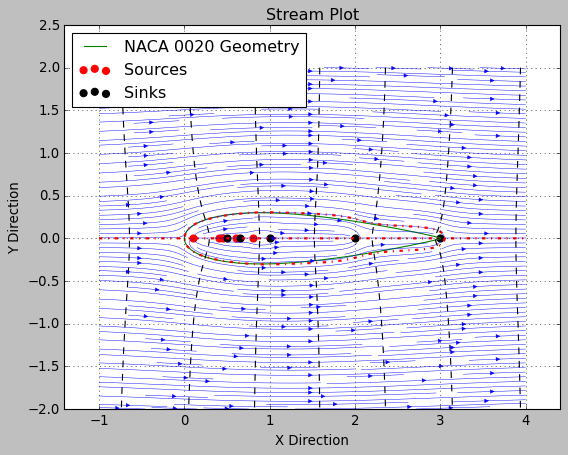

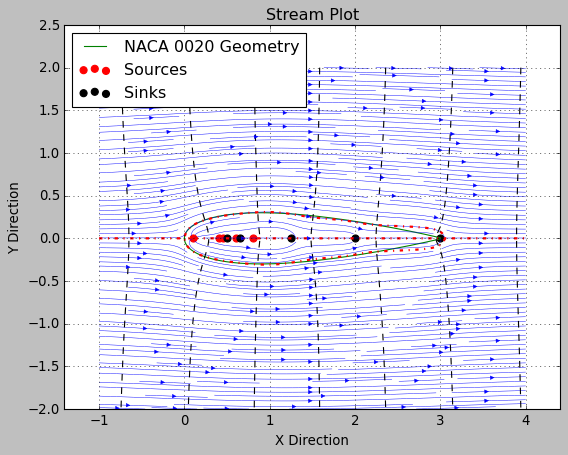

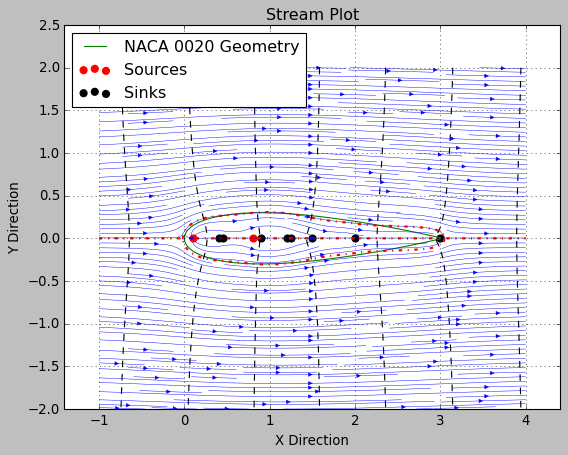

In [7]:
# Create guess

source_x_list = np.array([0.1, 0.4, 0.45, 0.5, 0.8, 0.6, 0.65, 1, 2, 3])
source_y_list = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
source_l_list = np.array([0.3, 0.05, 0.05, -0.05, 0.1, 0.05, -0.05, -0.1, -0.2, -0.15])


# Create freestream properties
u_inf = 0.5
v_inf = 0

# Define num points in meshgrid
N = 1000

x_bounds = np.linspace(-1, 4, N)
y_bounds = np.linspace(-2, 2, N)

X, Y = np.meshgrid(x_bounds, y_bounds)

# Create geometry data
airfoil_geometry = pd.DataFrame()

x, zup = NACAThicknessEquation(0, 0, 20, 1000)

airfoil_geometry["NACA 0020 X"], airfoil_geometry["NACA 0020"] = x, zup



airfoil_geometry *= 3
stream2 = CreateStreamPlot(source_x_list, source_y_list, source_l_list,
                           u_inf, v_inf, X, Y, N)

plt.xlim([-0.5, 3.5])
plt.ylim([-0.5, 0.5])

# Extract relevant geometry data

x *= 3
zup *= 3
ind = np.where(x < 3*0.75)
x = x[ind]
z = zup[ind]

ind = np.where(z > 0)
x = x[ind]
z = z[ind]

# Extract dividing streamline

streamlinedat = stream2.collections[3].get_paths()[0].vertices
streamlinedat = streamlinedat[np.where(streamlinedat[:, 1] > 0.0001)]
streamlinedat = streamlinedat[np.where(streamlinedat[:, 0] > 0)]
streamlinedat = streamlinedat[np.where(streamlinedat[:, 0] < 3*0.75)]


# Calculate error
arbitrary_error_metric = ArbitraryErrorMetric(streamlinedat[:, 0], 
                                              streamlinedat[:, 1],
                                              x, z)
string = f'Arbitrary error metric value = {arbitrary_error_metric}'
print(string)


# Plot airfoil on graph
plothus(stream2, airfoil_geometry["NACA 0020 X"], airfoil_geometry["NACA 0020"],
        datalabel='NACA 0020 Geometry')
plt.axis('equal')

#%%###########################

# Repeat for new guess

source_x_list = np.array([0.1, 0.4, 0.45, 0.5, 0.8, 0.6, 0.65, 1.25, 2, 3])
source_y_list = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
source_l_list = np.array([0.3, 0.05, 0.05, -0.05, 0.1, 0.05, -0.05, -0.2, -0.1, -0.15])

u_inf = 0.5
v_inf = 0

N = 1000

x_bounds = np.linspace(-1, 4, N)
y_bounds = np.linspace(-2, 2, N)

X, Y = np.meshgrid(x_bounds, y_bounds)


airfoil_geometry = pd.DataFrame()

x, zup = NACAThicknessEquation(0, 0, 20, 1000)

airfoil_geometry["NACA 0020 X"], airfoil_geometry["NACA 0020"] = x, zup



airfoil_geometry *= 3
stream2 = CreateStreamPlot(source_x_list, source_y_list, source_l_list,
                           u_inf, v_inf, X, Y, N)

plt.xlim([-0.5, 3.5])
plt.ylim([-0.5, 0.5])

x *= 3
zup *= 3
ind = np.where(x < 3*0.75)
x = x[ind]
z = zup[ind]

ind = np.where(z > 0)
x = x[ind]
z = z[ind]

streamlinedat = stream2.collections[3].get_paths()[0].vertices
streamlinedat = streamlinedat[np.where(streamlinedat[:, 1] > 0.0001)]
streamlinedat = streamlinedat[np.where(streamlinedat[:, 0] > 0)]
streamlinedat = streamlinedat[np.where(streamlinedat[:, 0] < 3*0.75)]

arbitrary_error_metric = ArbitraryErrorMetric(streamlinedat[:, 0], 
                                              streamlinedat[:, 1], x, z)

string = f'Arbitrary error metric value = {arbitrary_error_metric}'
print(string)



plothus(stream2, airfoil_geometry["NACA 0020 X"], airfoil_geometry["NACA 0020"],
        datalabel='NACA 0020 Geometry')
plt.axis('equal')

#%%###########################

# Repeat for final guess

source_x_list = np.array([0.1, 0.4, 0.45, 0.8, 0.9, 1.2, 1.5, 1.25, 2, 3])
source_y_list = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
source_l_list = np.array([0.4, -0.05, -0.05, 0.2 , -0.05, -0.05, -0.1, -0.1, -0.05, -0.15])

u_inf = 0.5
v_inf = 0

N = 1000

x_bounds = np.linspace(-1, 4, N)
y_bounds = np.linspace(-2, 2, N)

X, Y = np.meshgrid(x_bounds, y_bounds)


airfoil_geometry = pd.DataFrame()

x, zup = NACAThicknessEquation(0, 0, 20, 1000)

airfoil_geometry["NACA 0020 X"], airfoil_geometry["NACA 0020"] = x, zup



airfoil_geometry *= 3
stream2 = CreateStreamPlot(source_x_list, source_y_list, source_l_list, u_inf,
                           v_inf, X, Y, N)

# plt.xlim([-0.5, 3.5])

x *= 3
zup *= 3
ind = np.where(x < 3*0.75)
x = x[ind]
z = zup[ind]

ind = np.where(z > 0)
x = x[ind]
z = z[ind]

streamlinedat = stream2.collections[3].get_paths()[0].vertices
streamlinedat = streamlinedat[np.where(streamlinedat[:, 1] > 0.0001)]
streamlinedat = streamlinedat[np.where(streamlinedat[:, 0] > 0)]
streamlinedat = streamlinedat[np.where(streamlinedat[:, 0] < 3*0.75)]

arbitrary_error_metric = ArbitraryErrorMetric(streamlinedat[:, 0], 
                                              streamlinedat[:, 1],
                                              x, z)

string = f'Arbitrary error metric value = {arbitrary_error_metric}'
print(string)



plothus(stream2, airfoil_geometry["NACA 0020 X"], airfoil_geometry["NACA 0020"],
        datalabel='NACA 0020 Geometry')
plt.axis('equal')
plt.ylim([-2, 2.5])





## 3 | Source Wall

The goal for **Problem 3** is to approximate flow around a finite wall using vertical source/sink distributions of $N = 5, 11, 101$. 

For each distribution:

* Estimate the shape of the wall using dashed lines
* Report the height and width of each, and justify any differences
* Analyze differences between the simulation, and a viscous flow

### 3.1 | Approach

Having created a function which accepts multiple source/sink entities in **Problem 1**, creating a plot displaying an arbitrary number of sources and sinks was no issue. The problem can be solved by iterating over a list of the neccesary number of points in the column ```N``` (referred to in program as ```NN```, as ```N``` was previously used to refer to a meshgrid property. $y$-positions for each column are created using numpy's ```np.linspace()``` function, and $x$-positions are set by generating an array for each, and setting each to the appropriate value (either 0, or 0.25). The magnitude of the source strengths $\Lambda$ is also calculated from an array of 1's, and the ```NN``` value. The source data arrays are then concatenated using numpy's ```np.concatenate``` function, and used as inputs for the ```CreateStreamPlot()``` general function used in **Problem 1**.


### 3.2 | Equations

The source strength is given in the problem statement as:

$$\begin{equation}
    \Lambda = \pm \frac{5}{N}
\end{equation}$$

for N singularities in each column. 

### 3.3 | Code and Results

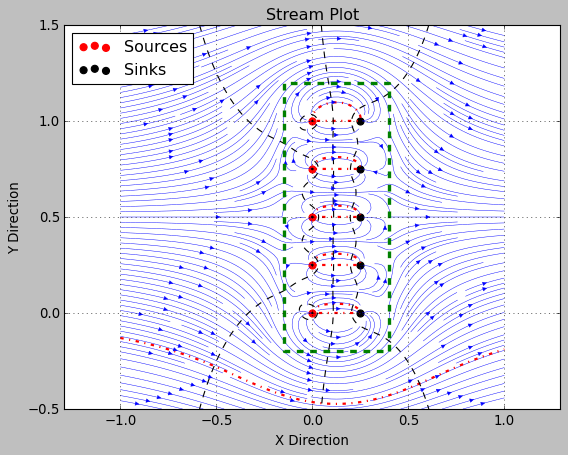

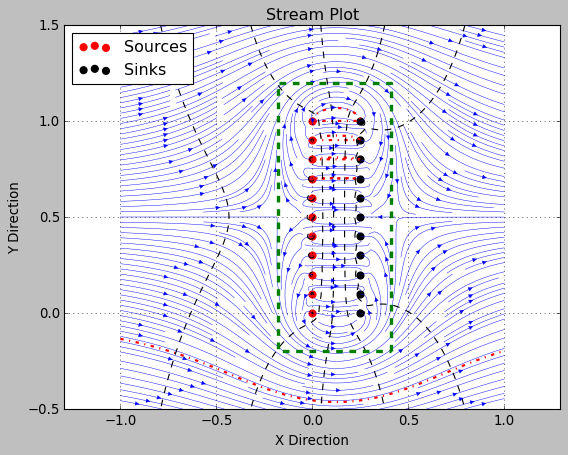

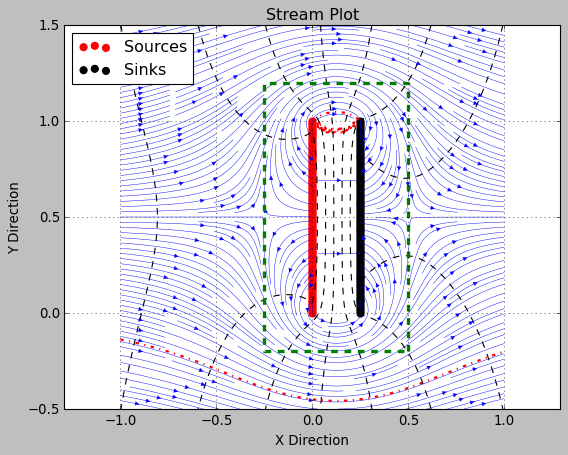

In [8]:
Nlist = np.array([5, 11, 101])
u_inf = 0.5
v_inf = 0

N = 2000

x_bounds = np.linspace(-1, 1, N)
y_bounds = np.linspace(-0.5, 1.5, N)

X, Y = np.meshgrid(x_bounds, y_bounds)

graphlist = np.empty((len(Nlist)), dtype=object)
i = 0

for NN in Nlist:
    
    ypos = np.linspace(0, 1, NN)
    xpos = np.zeros((NN))
    x_other = 0.25 * np.ones((NN))
    l = (5/NN) * np.ones(NN)
    
    source_y_list = np.concatenate((ypos, ypos))
    source_x_list = np.concatenate((xpos, x_other))
    source_l_list = np.concatenate((l, -l))

    graphlist[i] = CreateStreamPlot(source_x_list, source_y_list, source_l_list, u_inf, v_inf, X, Y, N)
    plt.axis('equal')
    plt.ylim([-0.5, 1.5])
    i += 1

# plot "wall"
boxx = np.array([0.4, 0.4, -0.15, -0.15, 0.4])
boxy = np.array([-0.2, 1.2, 1.2, -0.2, -0.2])
graphlist[0].plot(boxx, boxy, linewidth = 3, linestyle='--', label='"Wall"')
    

boxx = np.array([0.41, 0.41, -0.18, -0.18 , 0.41])
boxy = np.array([-0.2, 1.2, 1.2, -0.2, -0.2])
graphlist[1].plot(boxx, boxy, linewidth = 3, linestyle='--', label='"Wall"')

boxx = np.array([0.5, 0.5, -0.25, -0.25, 0.5])
boxy = np.array([-0.2, 1.2, 1.2, -0.2, -0.2])
graphlist[2].plot(boxx, boxy, linewidth = 3, linestyle='--', label='"Wall"')
    

The shape of the wall is estimated to be 1.4$ft$ in height, but with a varying width depending on the number of sources (ranging from 0.55 to 0.75 ft). The box itself is drawn so as to contain all internal flow between the sources.  Increasing the number of sources appears to slightly increase the width of the wall to a certain point. Note that in this inviscid flow model, there is no boundary layer separation at the rear of the "wall", resulting in a symmetrical flow profile. In a real, viscid flow scenario, the flow would be become turbulant and seperate. 



## 4 | Additional Aerodynamics Problems

For each problem, solve the given problem statement.

### 4.1 | Centre of Pressure

Consider a **NACA 2412** airfoil. A tabulation of the lift, drag, and moment ($c=\frac{1}{4}$ line) are listed below, with respect to angle of attack $\alpha$. Using this data, plot $\frac{x_{cp}}{c}$ as a function of $\alpha$ and discuss the results.


**$\alpha$**|**C$_l$**|**C$_d$**|**C$_m$**
:-----:|:-----:|:-----:|:-----:
-2|0.05|0.006|-0.042
0|0.25|0.006|-0.04
2|0.44|0.006|-0.038
4|0.64|0.007|-0.036
6|0.85|0.0075|-0.036
8|1.08|0.0092|-0.036
10|1.26|0.0115|-0.034
12|1.43|0.015|-0.03
14|1.56|0.0186|-0.025


#### 4.1.1 | Approach

The location of $x_{C_P}$ can be defined as a function of $C_l$ and $C_m$, given in the next section. Programming this relation as an anonymous function, and importing the data using pandas' ```pd.read_csv()``` function, $x_{C_P}$ can be found for all given points. It can then be plotted against $\alpha$.

#### 4.1.2 | Equations

$x_{C_P}$ is given by:

$$\begin{equation}
    x_{C_P} = \frac{-C_m}{C_l} + 0.25
\end{equation}$$


#### 4.1.3 | Code and Results

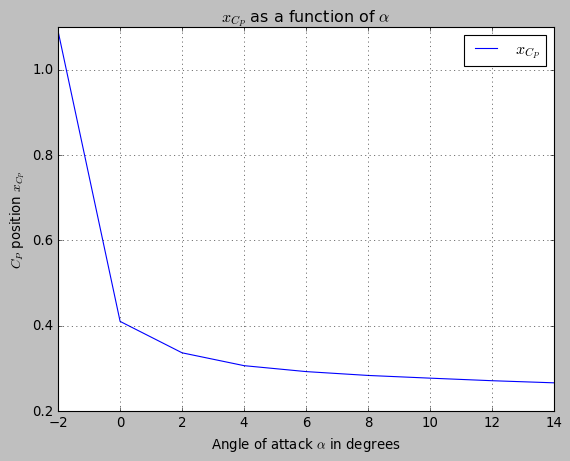

In [9]:
xcp = lambda cm, cl: (-cm/cl + 0.25)

FourOneDat = pd.read_csv("Data/Prob4Dat.csv")

FourOneDat["X_cp"] = xcp(FourOneDat["C_m"], FourOneDat["C_l"])

fig, fourplot = plt.subplots()
plothusly(fourplot, FourOneDat["alpha"], FourOneDat["X_cp"],
          xtitle=r'Angle of attack $\alpha$ in degrees',
          ytitle=r'$C_P$ position $x_{C_{P}}$',
          title=r'$x_{C_{P}}$ as a function of $\alpha$',
          datalabel=r'$x_{C_{P}}$')

Note that the location of the center of pressure is close to the quarter chord line at most angles of attack $\geq 2$.


### 4.2 | Dynamic Similarity

Consider two flows over geometrically similar airfoil shapes, one airfoil with twice the chord length of the other. The freestream properties over the smaller airfoil are given by:

$$\begin{equation}
    T_\infty = 199K, \rho_\infty = 1.23 kg-m^{-3}, V_\infty = 141 m-s^{-1} , c = L
\end{equation}$$

and the freestream properties over the larger airfoil are given as: 

$$\begin{equation}
    T_\infty = 400K, \rho_\infty = 1.739 kg-m^{-3}, V_\infty = 200 m-s^{-1} c = 2L
\end{equation}$$

Assuming $\mu$ and $a$ are proportional to $T^{\frac{1}{2}}$, determine if the two flows are dynamically similar.

#### 4.2.1 | Approach

Given that $\mu$ and $a$ are proportional to $T^{\frac{1}{2}}$, for the sake of equivalance, it can be assumed that both are _equal_ to $T^{\frac{1}{2}}$ (while this isn't true, the results will be equivalent if the flows are dynamically similar).

Flow dynamic similarity can be determined if the Reynold's number $Re$ and Mach number $M$ are equivalent. Both can be programmed as an anonymous function, and then compared.

#### 4.2.2 | Equations

Using the assumption given, Reynold's number can be expressed as:

$$\begin{equation}
    Re = \frac{\rho V L}{T^{1/2}}
\end{equation}$$

Mach number can be expressed as:

$$\begin{equation}
    M = \frac{V}{T^{1/2}}
\end{equation}$$


#### 4.2.3 | Code and Results


In [10]:

reynolds = lambda rho, V, L, T: (rho*V*L/(T**0.5))
Ma = lambda V, T: (V/(T**0.5))

T = 199
rho = 1.23
V = 141
L = 1

re1 = reynolds(rho, V, L, T)
ma1 = Ma(V, T)

T = 400
rho = 1.739
V = 200
L = 2

re2 = reynolds(rho, V, L, T)
ma2 = Ma(V, T)

string1 = f'Re_1 = {re1:.2f}, Re_2 = {re2:.2f}'
string2 = f'Ma_1 = {ma1:.2f}, Ma_2 = {ma2:.2f}'

print(string1)
print(string2)


Re_1 = 12.29, Re_2 = 34.78
Ma_1 = 10.00, Ma_2 = 10.00


The two flows have the same Mach number, but different Reynold's numbers. Therefore, they are not dynamically similar.


### 4.3 | Similarity Parameters

Consider a Lear Jet flying at a velocity of 200 $m/s$ at an altitude of 10$km$, where the density and temperature of the air are, respectively, 0.4147 $kg/m^3$ and 223 $K$. Consider also a $\frac{1}{5}$ scale model of the same jet as tested in a wind tunnel. Given that the pressure in the tunnel is 1$atm$, determine the necessary velocity, temperature, and density of the airflow required in the wind tunnel in order to match the lift and drag coefficients of the full-size aircraft.

#### 4.3.1 | Approach

To have the same lift and drag coefficients, the flows must be dynamically similar. In order to be dynamically similar, the Reynold's and Mach numbers for each flow must be identical (geometric similarity is already given in the problem statement). The problem must be solved algebraically, and then confirmed using the $Re$ and $Ma$ functions from the previous problem.

#### 4.3.2 | Equations

Using the same assumptions given in the previous problem statement, Reynold's number can be expressed as:

$$\begin{equation}
    Re = \frac{\rho V L}{T^{1/2}}
\end{equation}$$

Mach number can be expressed as:

$$\begin{equation}
    M = \frac{V}{T^{1/2}}
\end{equation}$$

Pressure can be expressed as:

$$\begin{equation}
    P = \rho R T
\end{equation}$$


$\mu$ and $a$ can be said to be proportional to $T^{\frac{1}{2}}$ given that the fluids are identical.

The gas constant for air $R$ is given as:

$$\begin{equation}
    R = 287 J/kg-K
\end{equation}$$

#### 4.3.3 | Code and Results 

Flow similarity problems can be solved by grouping variables. $V_2$ and $T_2$ can be grouped by the following:

$$\begin{equation}
    M_1 = M_2
\end{equation}$$

$$\begin{equation}
    \frac{V_1}{T_1^{1/2}} = \frac{V_2}{T_2^{1/2}}
\end{equation}$$

$$\begin{equation}
    \frac{V_2}{T_2^{1/2}} = 13.39
\end{equation}$$

Substituting into the Reynold's number equation:

$$\begin{equation}
    Re_1 = Re_2
\end{equation}$$

$$\begin{equation}
    \frac{\rho_1 V_1 L}{T_1^{1/2}} = \frac{\rho_2 V_2 0.2L}{T_2^{1/2}}
\end{equation}$$

$$\begin{equation}
    \frac{\rho_1 V_1}{T_1^{1/2}} \frac{T_2^{1/2}}{0.2 V_2} = \rho_2
\end{equation}$$

$$\begin{equation}
    \rho_2 = \frac{0.414* 200}{223^{1/2}} \frac{5 * 1}{13.39} =  2.07 kg-m^{-3}
\end{equation}$$

Having solved for density, temperature can be solved for using the relation for pressure:

$$\begin{equation}
    P_2 = \rho_2 R T_2
\end{equation}$$

$$\begin{equation}
    1.01\times10^5 = 2.07 \times 287 T_2
\end{equation}$$

$$\begin{equation}
    T_2 = \frac{1.01\times10^5}{2.07 \times 287} = 169.96 K 
\end{equation}$$

Having solved for temperature, velocity can be found using the previously grouped relationship:

$$\begin{equation}
    \frac{V_2}{T_2^{1/2}} = 13.39
\end{equation}$$

$$\begin{equation}
    V_2 = 13.39 * T_2^{1/2}
\end{equation}$$

$$\begin{equation}
    V_2 = 13.39 * T_2^{1/2} = 174.56 m-s^{-1}
\end{equation}$$

In [11]:

reynolds = lambda rho, V, L, T: (rho*V*L/(T**0.5))
Ma = lambda V, T: (V/(T**0.5))

T = 223
rho = 0.414
V = 200
L = 1

re1 = reynolds(rho, V, L, T)
ma1 = Ma(V, T)

T = 169.96
rho = 2.0704
V = 174.56
L = 0.2

re2 = reynolds(rho, V, L, T)
ma2 = Ma(V, T)

string1 = f'Re_1 = {re1:.2f}, Re_2 = {re2:.2f}'
string2 = f'Ma_1 = {ma1:.2f}, Ma_2 = {ma2:.2f}'

print(string1)
print(string2)


Re_1 = 5.54, Re_2 = 5.54
Ma_1 = 13.39, Ma_2 = 13.39


As the Reynolds number and Mach number match, the flows can be said to be dynamically similar, satisfying the problem statement.


### 4.4 | Lift Coefficient

Estimate the coefficient of lift for a Boeing 787 at maximum weight under the following conditions:

* Cruise at 42,000 $ft$ in standard atmosphere
* Landing in Denver in standard atmosphere (5,430 $ft$)
* Landing in San Francisco in standard atmosphere (Sea level)

In addition, estimate the coefficient of lift for a Cessna 152 at maximum gross weight for:

* Cruise at 7,000 $ft$ in standard atmosphere

#### 4.4.1 | Approach

Data for the 787 and Cessna 152 are given below, as found online:

|            | Max. Gross Weight | Cruise Speed | Landing Speed | Wing Area   |
|------------|-------------------|--------------|---------------|-------------|
| Boeing 787 | 559,974.146 lb    | 561 mph      | 166 mph       | 511 ft$^2$  |
| Cessna 152 | 1668.9 lb         | 123 mph      | 49.5 mph      | 14.9 ft$^2$ |

Using the lift equation, the airspeed as provided by the above table, and data for standard atmosphere (Anderson appendix), and the altitudes for each of the conditions, the coefficient of lift can be found using the lift equation.

#### 4.4.2 | Equations

The lift equation is given by:

$$\begin{equation}
    L = \frac{1}{2}\rho_{\infty} V_{\infty}^2 S C_L
\end{equation}$$

Rearranging to solve for C$_L$:

$$\begin{equation}
    C_L = \frac{2L}{\rho_{\infty} V_{\infty}^2 S}
\end{equation}$$

#### 4.4.3 | Code and Results

In [12]:
C_L = lambda L, rho, vel_inf, wing_area:  (L * 2 / (rho * vel_inf**2 * wing_area))

mph2fps = lambda mph: (mph * 1.46667)

rho = 5.3365E-4
vel_inf = mph2fps(561)
wing_area = 511
L = 559974.146

C_L_1 = C_L(L, rho, vel_inf, wing_area)

string = f'C_L for 787 at cruise at 42k ft is {C_L_1}'

print(string)

rho = 2.1074E-3
vel_inf = mph2fps(166)
wing_area = 511
L = 559974.146

C_L_2 = C_L(L, rho, vel_inf, wing_area)

string = f'C_L for 787 landing at DIA is {C_L_2}'

print(string)

rho = 2.3769E-3
vel_inf = mph2fps(166)
wing_area = 511
L = 559974.146

C_L_3 = C_L(L, rho, vel_inf, wing_area)

string = f'C_L for 787 landing at SFO is {C_L_3}'

print(string)

rho = 1.9270E-3
vel_inf = mph2fps(49.5)
wing_area = 14.9
L = 1668.9

C_L_4 = C_L(L, rho, vel_inf, wing_area)

string = f'C_L for Cessna 152 at cruise at 7k ft is {C_L_4}'

print(string)



C_L for 787 at cruise at 42k ft is 6.066385679293238
C_L for 787 landing at DIA is 17.54482748496257
C_L for 787 landing at SFO is 15.55554269923435
C_L for Cessna 152 at cruise at 7k ft is 22.055510363898435
